<a href="https://colab.research.google.com/github/ShaunakSen/Deep-Learning/blob/master/TensorFlow_Tutorial_01_Simple_Linear_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow Tutorial #01 - Simple Linear Model

[link](https://www.youtube.com/watch?v=wuo4JdG3SvU&list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ&index=3)

In [4]:
import os
work_dir = "/content/TensorFlow-Tutorials/"
if os.getcwd() != work_dir:
  !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials
os.chdir(work_dir)

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 477 (delta 1), reused 3 (delta 1), pack-reused 471
Receiving objects: 100% (477/477), 62.51 MiB | 29.62 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [7]:
tf.__version__

'1.14.0'

### Load the data

In [6]:

from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!


The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.



In [16]:
print ("train:", data.x_train.shape, data.y_train.shape)
print ("valid:", data.x_val.shape, data.y_val.shape)
print ("test", data.x_test.shape, data.y_test.shape)

train: (55000, 784) (55000, 10)
valid: (5000, 784) (5000, 10)
test (10000, 784) (10000, 10)


The labels for each image is an array of size 10, where one value will be 1, the index denoting the class

In [14]:
data.y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Copy some of the data-dimensions for convenience.

In [18]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

print (img_size_flat, img_shape, num_classes)

784 (28, 28) 10


The output-data is loaded as both integer class-numbers and so-called One-Hot encoded arrays. This means the class-numbers have been converted from a single integer to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is 1 and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:



In [20]:
data.y_test[0:5,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

We also need the classes as integers for various comparisons and performance measures. These can be found from the One-Hot encoded arrays by taking the index of the highest element using the np.argmax() function. But this has already been done for us when the data-set was loaded, so we can see the class-number for the first five images in the test-set. Compare these to the One-Hot encoded arrays above.



In [21]:
data.y_test_cls[0:5]


array([7, 2, 1, 0, 4])

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.



In [0]:
def plot_images(images, cls_true, cls_pred=None):
  assert len(images) == len(cls_true) == 9
  
  # Create figure with 3x3 sub-plots.
  fig, axes = plt.subplots(3, 3)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  
  for i, ax in enumerate(axes.flat):
    # Plot image: reshape it first
    
    ax.imshow(images[i].reshape(img_shape), cmap='binary')
    
    # Show true and predicted classes.
    
    if cls_pred is None:
      xlabel = "True: {0}".format(cls_true[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
      
    
    # set the label
    ax.set_xlabel(xlabel)
        
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

Plot a few images to see if data is correct

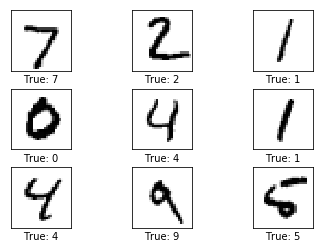

In [29]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) that are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

- Placeholder variables used to feed input into the graph.
- Model variables that are going to be optimized so as to make the model perform better.
- The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

### Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to `[None, img_size_flat]`, where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [0]:
x = tf.placeholder(dtype=tf.float32, shape=[None, img_size_flat])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.



In [0]:
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

Finally we have the placeholder variable for the true class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to `[None]` which means the placeholder variable is a one-dimensional vector of arbitrary length.



In [0]:
y_true_cls = tf.placeholder(dtype=tf.int64, shape=[None])

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.


The first variable that must be optimized is called weights and is defined here as a TensorFlow variable that must be initialized with zeros and whose shape is `[img_size_flat, num_classes]`, so it is a 2-dimensional tensor (or matrix) with img_size_flat rows and num_classes columns.



In [33]:
# shape: 784 x 10
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

print(weights.shape)

(784, 10)


The second variable that must be optimized is called biases and is defined as a 1-dimensional tensor (or vector) of length num_classes.



In [34]:
biases = tf.Variable(tf.zeros([num_classes]))

print (biases.shape)

(10,)


### Model

